# Прогнозирование цен потребительского ритейла по тестовой выборке на основе глубоких нейронных сетей
__Выполнил:__ *Домченко Максим*

__Студент группы:__ *РИМ-130962*

In [17]:
# Подключение Google Drive к Colab
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
ROOT = Path('/content/drive/MyDrive')

# Настройка структуры папок проекта
PROJECT_DIR = ROOT / 'price_forecasting'
DATA = PROJECT_DIR / 'data'
RAW = DATA / 'raw'
PROCESSED = DATA / 'processed'
MODELS = PROJECT_DIR / 'models'
MODELS.mkdir(exist_ok=True)

print('Проектная папка подключена:', PROJECT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Проектная папка подключена: /content/drive/MyDrive/price_forecasting


In [18]:
!pip install pytorch-forecasting

In [19]:
# Основные библиотеки
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Метрики
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Pytorch и TFT
import torch
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer
from torch.utils.data import DataLoader  # Исправлено здесь
from pytorch_forecasting.models import TemporalFusionTransformer

# Прочее
import pickle

# Версии библиотек и проверка GPU
print("Версия Pandas:", pd.__version__)
print("Версия NumPy:", np.__version__)
print("Версия PyTorch:", torch.__version__)
print("Доступна GPU:", torch.cuda.is_available())

Версия Pandas: 2.2.2
Версия NumPy: 2.0.2
Версия PyTorch: 2.6.0+cu124
Доступна GPU: True


In [20]:
# Загрузка данных
train_df = pd.read_parquet(PROCESSED / 'train_features_final.parquet')
val_df = pd.read_parquet(PROCESSED / 'val_features_final.parquet')
test_df = pd.read_parquet(PROCESSED / 'test_features_final.parquet')

# Выбор магазина (например, CA_1)
store_id = 'CA_1'
train_df = train_df[train_df['store_id'] == store_id]
val_df = val_df[val_df['store_id'] == store_id]
test_df = test_df[test_df['store_id'] == store_id]

# Проверка размеров
print(f"Размер train_df: {train_df.shape}")
print(f"Размер val_df: {val_df.shape}")
print(f"Размер test_df: {test_df.shape}")

Размер train_df: (3673873, 22)
Размер val_df: (599263, 22)
Размер test_df: (600503, 22)


In [21]:
# Выведем признаки и их типы данных
print("Список признаков и их типы данных:")
for col in train_df.columns:
    print(f"{col}: {train_df[col].dtype}")

Список признаков и их типы данных:
store_id: category
item_id: category
wm_yr_wk: int64
sell_price: float64
date: datetime64[ns]
month: int32
year: int64
event_name_1: object
event_type_1: object
event_name_2: object
event_type_2: object
snap_CA: int64
snap_TX: int64
snap_WI: int64
day_of_week: int32
is_weekend: int64
log_sell_price: float64
event_flag: int64
event_type_National: int64
event_type_Cultural: int64
event_type_Religious: int64
event_type_Sporting: int64


In [22]:
# Приводим категориальные признаки к строковому типу
for df in [train_df, val_df, test_df]:
    df['month'] = df['month'].astype(str)
    df['year'] = df['year'].astype(str)
    df['event_name_1'] = df['event_name_1'].astype(str)
    df['event_type_1'] = df['event_type_1'].astype(str)
    df['snap_CA'] = df['snap_CA'].astype(str)
    df['day_of_week'] = df['day_of_week'].astype(str)
    df['is_weekend'] = df['is_weekend'].astype(str)

# Определение таргета и признаков
target = 'log_sell_price'

# Признаки для модели
time_idx = 'date'
group_ids = ['store_id', 'item_id']  # добавлен store_id для корректности группировки
categorical_features = [
    'month', 'year', 'day_of_week', 'is_weekend',
    'event_name_1', 'event_type_1', 'snap_CA'
]

# Числовые признаки без sell_price
numerical_features = [
    'event_flag', 'event_type_National', 'event_type_Cultural',
    'event_type_Religious', 'event_type_Sporting'
]

# Финальный список признаков
features = group_ids + categorical_features + numerical_features

print("Таргет:", target)
print("Категориальные признаки:", categorical_features)
print("Числовые признаки:", numerical_features)
print("Все признаки:", features)

Таргет: log_sell_price
Категориальные признаки: ['month', 'year', 'day_of_week', 'is_weekend', 'event_name_1', 'event_type_1', 'snap_CA']
Числовые признаки: ['event_flag', 'event_type_National', 'event_type_Cultural', 'event_type_Religious', 'event_type_Sporting']
Все признаки: ['store_id', 'item_id', 'month', 'year', 'day_of_week', 'is_weekend', 'event_name_1', 'event_type_1', 'snap_CA', 'event_flag', 'event_type_National', 'event_type_Cultural', 'event_type_Religious', 'event_type_Sporting']


In [23]:
# Убедимся, что дата отсортирована по 'date'
train_df = train_df.sort_values(by='date')
val_df = val_df.sort_values(by='date')
test_df = test_df.sort_values(by='date')

# Подготовим индексы времени для модели
time_idx = 'time_idx'
for df in [train_df, val_df, test_df]:
    df[time_idx] = (df['date'] - train_df['date'].min()).dt.days

# Проверим промежуток времени в данных
print("Диапазон дат в train:", train_df['date'].min(), train_df['date'].max())
print("Диапазон дат в val:", val_df['date'].min(), val_df['date'].max())
print("Диапазон дат в test:", test_df['date'].min(), test_df['date'].max())

# Проверка итоговых данных
train_df.head()

Диапазон дат в train: 2011-01-29 00:00:00 2015-05-22 00:00:00
Диапазон дат в val: 2015-05-23 00:00:00 2015-12-05 00:00:00
Диапазон дат в test: 2015-12-06 00:00:00 2016-06-19 00:00:00


,store_id,item_id,wm_yr_wk,sell_price,date,month,year,event_name_1,event_type_1,event_name_2,...,snap_WI,day_of_week,is_weekend,log_sell_price,event_flag,event_type_National,event_type_Cultural,event_type_Religious,event_type_Sporting,time_idx
0,CA_1,FOODS_1_001,11101,2.00,2011-01-29,1,2011,NoEvent,NoEvent,NoEvent,...,0,5,1,1.098612,0,0,0,0,0,0
1073989,CA_1,FOODS_3_271,11101,4.98,2011-01-29,1,2011,NoEvent,NoEvent,NoEvent,...,0,5,1,1.788421,0,0,0,0,0,0
1071903,CA_1,FOODS_3_269,11101,2.84,2011-01-29,1,2011,NoEvent,NoEvent,NoEvent,...,0,5,1,1.345472,0,0,0,0,0,0
3349003,CA_1,HOUSEHOLD_2_259,11101,7.67,2011-01-29,1,2011,NoEvent,NoEvent,NoEvent,...,0,5,1,2.159869,0,0,0,0,0,0
1069257,CA_1,FOODS_3_267,11101,1.98,2011-01-29,1,2011,NoEvent,NoEvent,NoEvent,...,0,5,1,1.091923,0,0,0,0,0,0


In [24]:
!pip install pytorch-forecasting pytorch-lightning

In [25]:
# Определение разумных длин окон
max_encoder_length = 60
max_prediction_length = 28

print(f"Максимальная длина окна кодировщика: {max_encoder_length}")
print(f"Максимальная длина окна прогнозирования: {max_prediction_length}")

# Удаление пропусков (если они есть)
train_df.dropna(inplace=True)
val_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Проверим число записей по каждой группе
group_counts = train_df.groupby(group_ids, observed=True).size()
valid_groups = group_counts[group_counts >= (max_encoder_length + max_prediction_length)].index

train_df_filtered = train_df.set_index(group_ids).loc[valid_groups].reset_index()
val_df_filtered = val_df.set_index(group_ids).loc[valid_groups].reset_index()
test_df_filtered = test_df.set_index(group_ids).loc[valid_groups].reset_index()

print(f"Размер train_df до фильтрации: {train_df.shape}")
print(f"Размер train_df после фильтрации: {train_df_filtered.shape}")
print(f"Число групп после фильтрации: {train_df_filtered.groupby(group_ids, observed=True).ngroups}")


Максимальная длина окна кодировщика: 60
Максимальная длина окна прогнозирования: 28
Размер train_df до фильтрации: (3673873, 23)
Размер train_df после фильтрации: (3672914, 23)
Число групп после фильтрации: 3020


In [26]:
from pytorch_forecasting.data.encoders import NaNLabelEncoder

# Создание датасета для обучения
training = TimeSeriesDataSet(
    train_df_filtered,
    time_idx=time_idx,
    target=target,
    group_ids=group_ids,
    max_encoder_length=max_encoder_length,
    min_encoder_length=max_encoder_length // 2,
    max_prediction_length=max_prediction_length,
    min_prediction_length=1,
    static_categoricals=group_ids,
    time_varying_known_categoricals=categorical_features,
    time_varying_known_reals=['time_idx'],
    time_varying_unknown_reals=[target] + numerical_features,
    target_normalizer=GroupNormalizer(groups=group_ids),
    categorical_encoders={col: NaNLabelEncoder(add_nan=True) for col in categorical_features + group_ids},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

In [27]:
# Создание датасетов для валидации и теста
validation = TimeSeriesDataSet.from_dataset(
    training, val_df_filtered, predict=True, stop_randomization=True
)
testing = TimeSeriesDataSet.from_dataset(
    training, test_df_filtered, predict=True, stop_randomization=True
)

# Создание DataLoader'ов
batch_size = 12288
num_workers = 12

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=num_workers)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=num_workers)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=num_workers)

# Проверка загрузки данных
x, y = next(iter(train_dataloader))
print("Размерность батча (x):", x['encoder_cont'].shape)
print("Размерность таргета (y):", y[0].shape)

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/encoders.py:400: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


Размерность батча (x): torch.Size([12288, 60, 11])
Размерность таргета (y): torch.Size([12288, 28])


In [28]:
from pytorch_forecasting.metrics import MAE, RMSE, MAPE

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=64,
    attention_head_size=2,
    dropout=0.2,
    hidden_continuous_size=32,
    loss=RMSE(),
    log_interval=10,
    optimizer="Adam",  # заменил Ranger на Adam
    reduce_on_plateau_patience=4,
)

print(f"Количество параметров модели: {(tft.size()/1e3):.1f}K")

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Количество параметров модели: 502.2K


In [29]:
# ─────────────────────────────────────────────────────────────
# Загрузка сохранённой TFT-модели
# ─────────────────────────────────────────────────────────────
from pytorch_forecasting.models import TemporalFusionTransformer

model_path = MODELS / "tft_model_limited_dataset.ckpt"

# map_location='cpu' гарантирует, что весы попадут в ОЗУ,
# даже если GPU недоступна/не нужна
tft_loaded = TemporalFusionTransformer.load_from_checkpoint(
    model_path,
    map_location="cpu",
)
tft_loaded.eval()

print(f"Модель успешно загружена из: {model_path}")

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Модель успешно загружена из: /content/drive/MyDrive/price_forecasting/models/tft_model_limited_dataset.ckpt


In [55]:
# Находим товар, который чаще всего менял цену в магазине CA_1
store_id = 'CA_1'

# фильтруем train_df по магазину CA_1
ca_1_df = train_df[train_df['store_id'] == store_id]

# считаем количество уникальных цен по товарам
price_changes = ca_1_df.groupby('item_id')['sell_price'].nunique().reset_index()
price_changes.columns = ['item_id', 'price_changes']
price_changes = price_changes.sort_values(by='price_changes', ascending=False)

# выводим товар, который чаще всего менял цену
top_item_id = price_changes.iloc[0]['item_id']
print(f"Товар с максимальным числом изменений цены в магазине {store_id}: {top_item_id}")
price_changes.head(25)

Товар с максимальным числом изменений цены в магазине CA_1: FOODS_1_129


<ipython-input-55-23dd30c1e03e>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_changes = ca_1_df.groupby('item_id')['sell_price'].nunique().reset_index()


,item_id,price_changes
126,FOODS_1_129,12
93,FOODS_1_095,12
94,FOODS_1_096,12
596,FOODS_2_382,9
166,FOODS_1_170,9
144,FOODS_1_147,9
104,FOODS_1_107,9
603,FOODS_2_389,9
85,FOODS_1_087,9
861,FOODS_3_249,9


In [164]:
# Задаём параметры для поиска товара
store_id = "CA_1"

# Берём только тестовый период
ca_1_test_df = test_df[(test_df["store_id"] == store_id)]

# Считаем количество уникальных цен по товарам за тестовый период
price_changes_test = (
    ca_1_test_df.groupby("item_id")["sell_price"]
    .nunique()
    .reset_index()
    .rename(columns={"sell_price": "price_changes"})
    .sort_values(by="price_changes", ascending=False)
)

# Выводим товар с максимальным количеством изменений цены за тестовый период
top_item_test_period = price_changes_test.iloc[0]["item_id"]
print(f"Товар с максимальным числом изменений цены в магазине {store_id} (тестовый период): {top_item_test_period}")

# Посмотрим топ-10 товаров по изменениям цен
price_changes_test.head(10)


Товар с максимальным числом изменений цены в магазине CA_1 (тестовый период): FOODS_1_095


<ipython-input-164-b853e3bae520>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ca_1_test_df.groupby("item_id")["sell_price"]


,item_id,price_changes
93,FOODS_1_095,6
96,FOODS_1_098,3
20,FOODS_1_022,3
524,FOODS_2_310,3
680,FOODS_3_068,3
1073,FOODS_3_461,3
669,FOODS_3_057,3
2171,HOUSEHOLD_1_174,3
1017,FOODS_3_405,3
1097,FOODS_3_485,3


In [201]:
# Выбираем товар и магазин для прогноза
selected_store_id = 'CA_1'
selected_item_id = 'FOODS_1_095'

# Подготовим тестовый набор для выбранной группы
selected_test_df = test_df_filtered[
    (test_df_filtered['store_id'] == selected_store_id) &
    (test_df_filtered['item_id'] == selected_item_id)
].copy()

# Проверим данные
selected_test_df.head()

,store_id,item_id,wm_yr_wk,sell_price,date,month,year,event_name_1,event_type_1,event_name_2,...,snap_WI,day_of_week,is_weekend,log_sell_price,event_flag,event_type_National,event_type_Cultural,event_type_Religious,event_type_Sporting,time_idx
18321,CA_1,FOODS_1_095,11545,3.24,2015-12-06,12,2015,NoEvent,NoEvent,NoEvent,...,1,6,1,1.444563,0,0,0,0,0,1772
18322,CA_1,FOODS_1_095,11545,3.24,2015-12-07,12,2015,NoEvent,NoEvent,NoEvent,...,0,0,0,1.444563,0,0,0,0,0,1773
18323,CA_1,FOODS_1_095,11545,3.24,2015-12-08,12,2015,NoEvent,NoEvent,NoEvent,...,1,1,0,1.444563,0,0,0,0,0,1774
18324,CA_1,FOODS_1_095,11545,3.24,2015-12-09,12,2015,NoEvent,NoEvent,NoEvent,...,1,2,0,1.444563,0,0,0,0,0,1775
18325,CA_1,FOODS_1_095,11545,3.24,2015-12-10,12,2015,NoEvent,NoEvent,NoEvent,...,0,3,0,1.444563,0,0,0,0,0,1776


In [202]:
# Создаем датасет для прогноза
selected_test_ds = TimeSeriesDataSet.from_dataset(
    training, selected_test_df, predict=True, stop_randomization=True
)

# DataLoader для прогноза
selected_test_loader = selected_test_ds.to_dataloader(train=False, batch_size=64, num_workers=4)

# Проверим размеры батча
x, y = next(iter(selected_test_loader))
print(f"Размерность батча (x):", x['encoder_cont'].shape)

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/encoders.py:400: UserWarning: Found 1 unknown classes which were set to NaN
  warnings.warn(


Размерность батча (x): torch.Size([1, 60, 11])


In [203]:
# Выполняем прогноз
selected_predictions = tft_loaded.predict(selected_test_loader)

# Переносим тензор на CPU и преобразуем в NumPy
selected_predictions_cpu = selected_predictions.cpu().numpy()

# TFT делает прогноз на последние max_prediction_length дат из данных
selected_test_df_sorted = selected_test_df.sort_values('date')
selected_test_df_pred = selected_test_df_sorted.iloc[-selected_predictions_cpu.shape[1]:].copy()

# Добавляем прогнозы в датафрейм
selected_test_df_pred['log_sell_price_pred'] = selected_predictions_cpu.flatten()

# Посмотрим результат
selected_test_df_pred[['date', 'log_sell_price', 'log_sell_price_pred']].head()

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


,date,log_sell_price,log_sell_price_pred
18490,2016-05-23,1.427916,1.357028
18491,2016-05-24,1.427916,1.365577
18492,2016-05-25,1.427916,1.380936
18493,2016-05-26,1.427916,1.378965
18494,2016-05-27,1.427916,1.377524


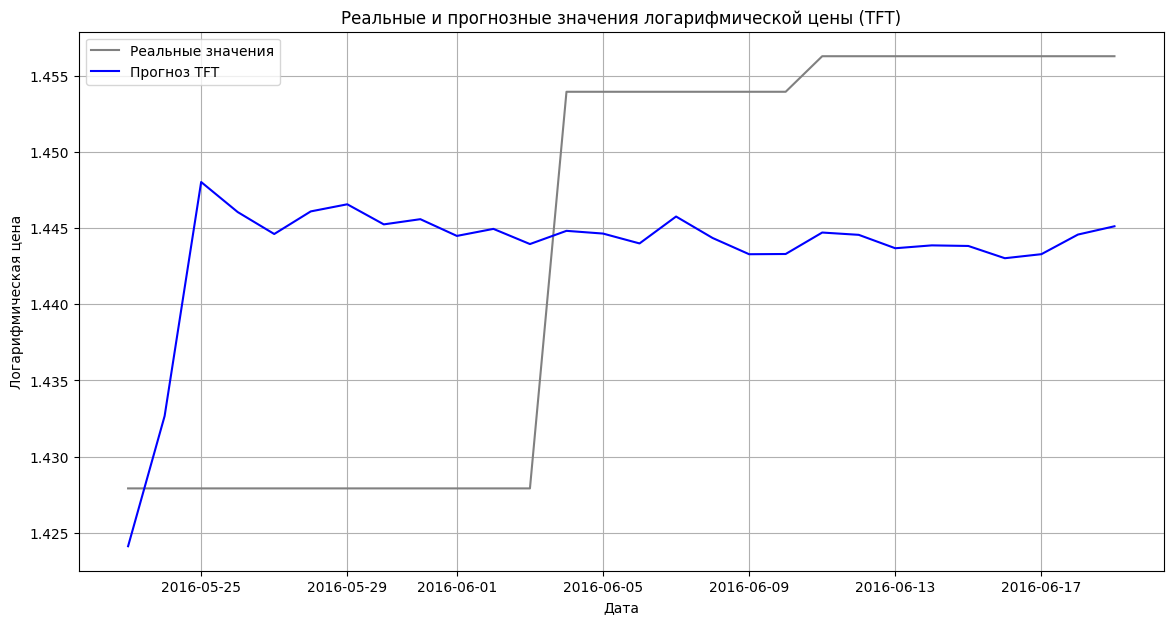

In [206]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# График реальных значений
plt.plot(selected_test_df_pred['date'], selected_test_df_pred['log_sell_price'],
         label='Реальные значения', color='gray')

# График прогнозных значений
plt.plot(selected_test_df_pred['date'], selected_test_df_pred['log_sell_price_pred'],
         label='Прогноз TFT', color='blue')

plt.title('Реальные и прогнозные значения логарифмической цены (TFT)')
plt.xlabel('Дата')
plt.ylabel('Логарифмическая цена')
plt.legend()
plt.grid(True)
plt.show()